In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [3]:
df = pd.read_excel("premiums_young.xlsx")
df.head()

,Unnamed: 0,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,9,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,10,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,16,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,19,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


In [4]:
df.shape

(20096, 14)

In [5]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.head(1)

,unnamed:_0,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [6]:
df.isna().sum()

unnamed:_0               0
age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
df.isna().sum()

unnamed:_0               0
age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [9]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)

In [10]:
df.describe()

,unnamed:_0,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,24962.130513,21.494375,0.718019,22.510851,8142.096267
std,14438.360343,2.294052,0.940713,23.420493,2749.906347
min,4.000000,18.000000,-3.000000,1.000000,3501.000000
25%,12350.250000,19.000000,0.000000,6.000000,6022.250000
50%,24903.500000,22.000000,0.000000,16.000000,7939.000000
75%,37404.750000,23.000000,1.000000,31.000000,9561.000000
max,49998.000000,25.000000,3.000000,790.000000,18186.000000


In [11]:
df[df.number_of_dependants < 0]["number_of_dependants"].value_counts()

number_of_dependants
-3    12
-1    10
Name: count, dtype: int64

In [12]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

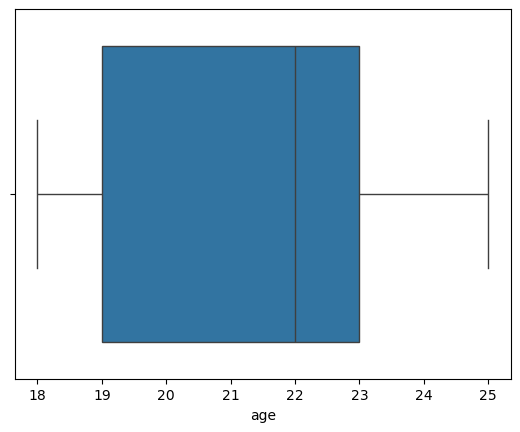

In [13]:
sns.boxplot(x=df['age'])
plt.show()

In [14]:
df1 = df[df.age<=100].copy()
df1.describe()

,unnamed:_0,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,24962.130513,21.494375,0.722598,22.510851,8142.096267
std,14438.360343,2.294052,0.937200,23.420493,2749.906347
min,4.000000,18.000000,0.000000,1.000000,3501.000000
25%,12350.250000,19.000000,0.000000,6.000000,6022.250000
50%,24903.500000,22.000000,0.000000,16.000000,7939.000000
75%,37404.750000,23.000000,1.000000,31.000000,9561.000000
max,49998.000000,25.000000,3.000000,790.000000,18186.000000


In [15]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

In [16]:
df1.income_lakhs.quantile([0.25, 0.75])

0.25     6.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [17]:
get_iqr_bounds(df1.income_lakhs)

(-31.5, 68.5)

In [18]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

100.0

In [19]:
df2 = df1[df1.income_lakhs<=quantile_threshold].copy()

In [20]:
df2.describe()

,unnamed:_0,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,24965.022902,21.494474,0.722742,22.390371,8141.799263
std,14438.231315,2.294248,0.937238,21.732062,2749.912486
min,4.000000,18.000000,0.000000,1.000000,3501.000000
25%,12356.500000,19.000000,0.000000,6.000000,6022.000000
50%,24910.500000,22.000000,0.000000,16.000000,7939.000000
75%,37406.500000,23.000000,1.000000,31.000000,9561.000000
max,49998.000000,25.000000,3.000000,100.000000,18186.000000


In [21]:
numeric_columns = df1.select_dtypes(include=["float64", "int64"]).columns

IndexError: index 2 is out of bounds for axis 0 with size 2

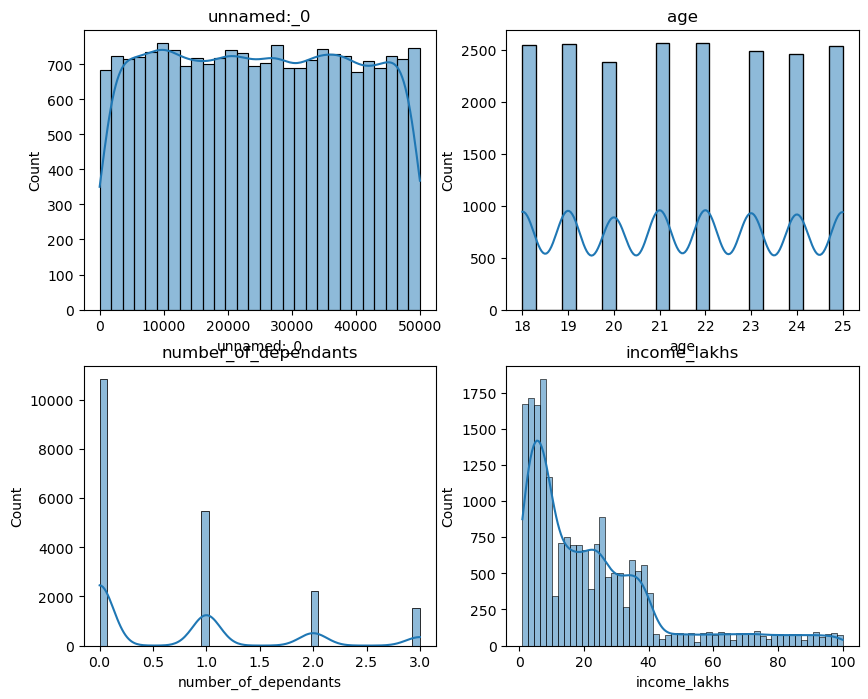

In [22]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))  # Adjust the size as necessary

for i, column in enumerate(numeric_columns):
    ax = axs[i//2, i%2]  # Determines the position of the subplot in the grid
    sns.histplot(df2[column], kde=True, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

<Axes: xlabel='age', ylabel='annual_premium_amount'>

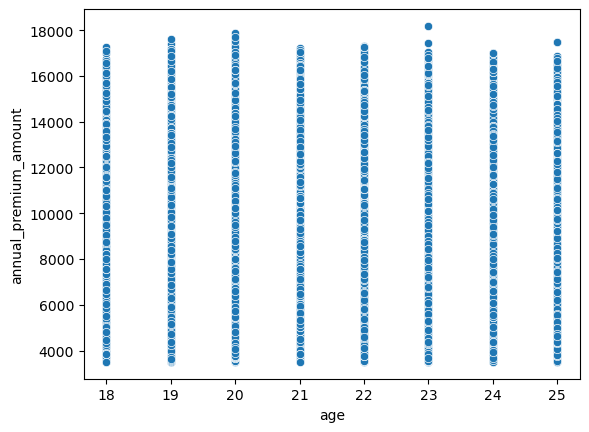

In [69]:
sns.scatterplot(df2, x='age', y='annual_premium_amount')

In [70]:
categorical_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']
for col in categorical_cols:
    print(col, ":", df2[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [72]:
df2['smoking_status'].replace({
    'Smoking=0':'No Smoking',
    'Does Not Smoke':'No Smoking',
    'Not Smoking':'No Smoking'
},inplace=True)
df2['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

In [75]:
pct_count = df2['gender'].value_counts(normalize=True)
pct_count

gender
Male      0.550383
Female    0.449617
Name: proportion, dtype: float64

<Axes: xlabel='gender'>

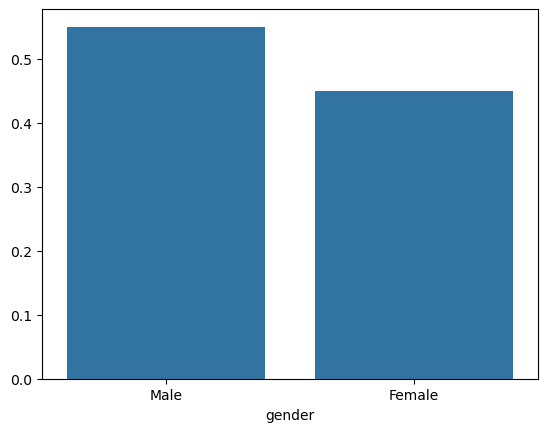

In [77]:
sns.barplot(x=pct_count.index, y=pct_count.values)

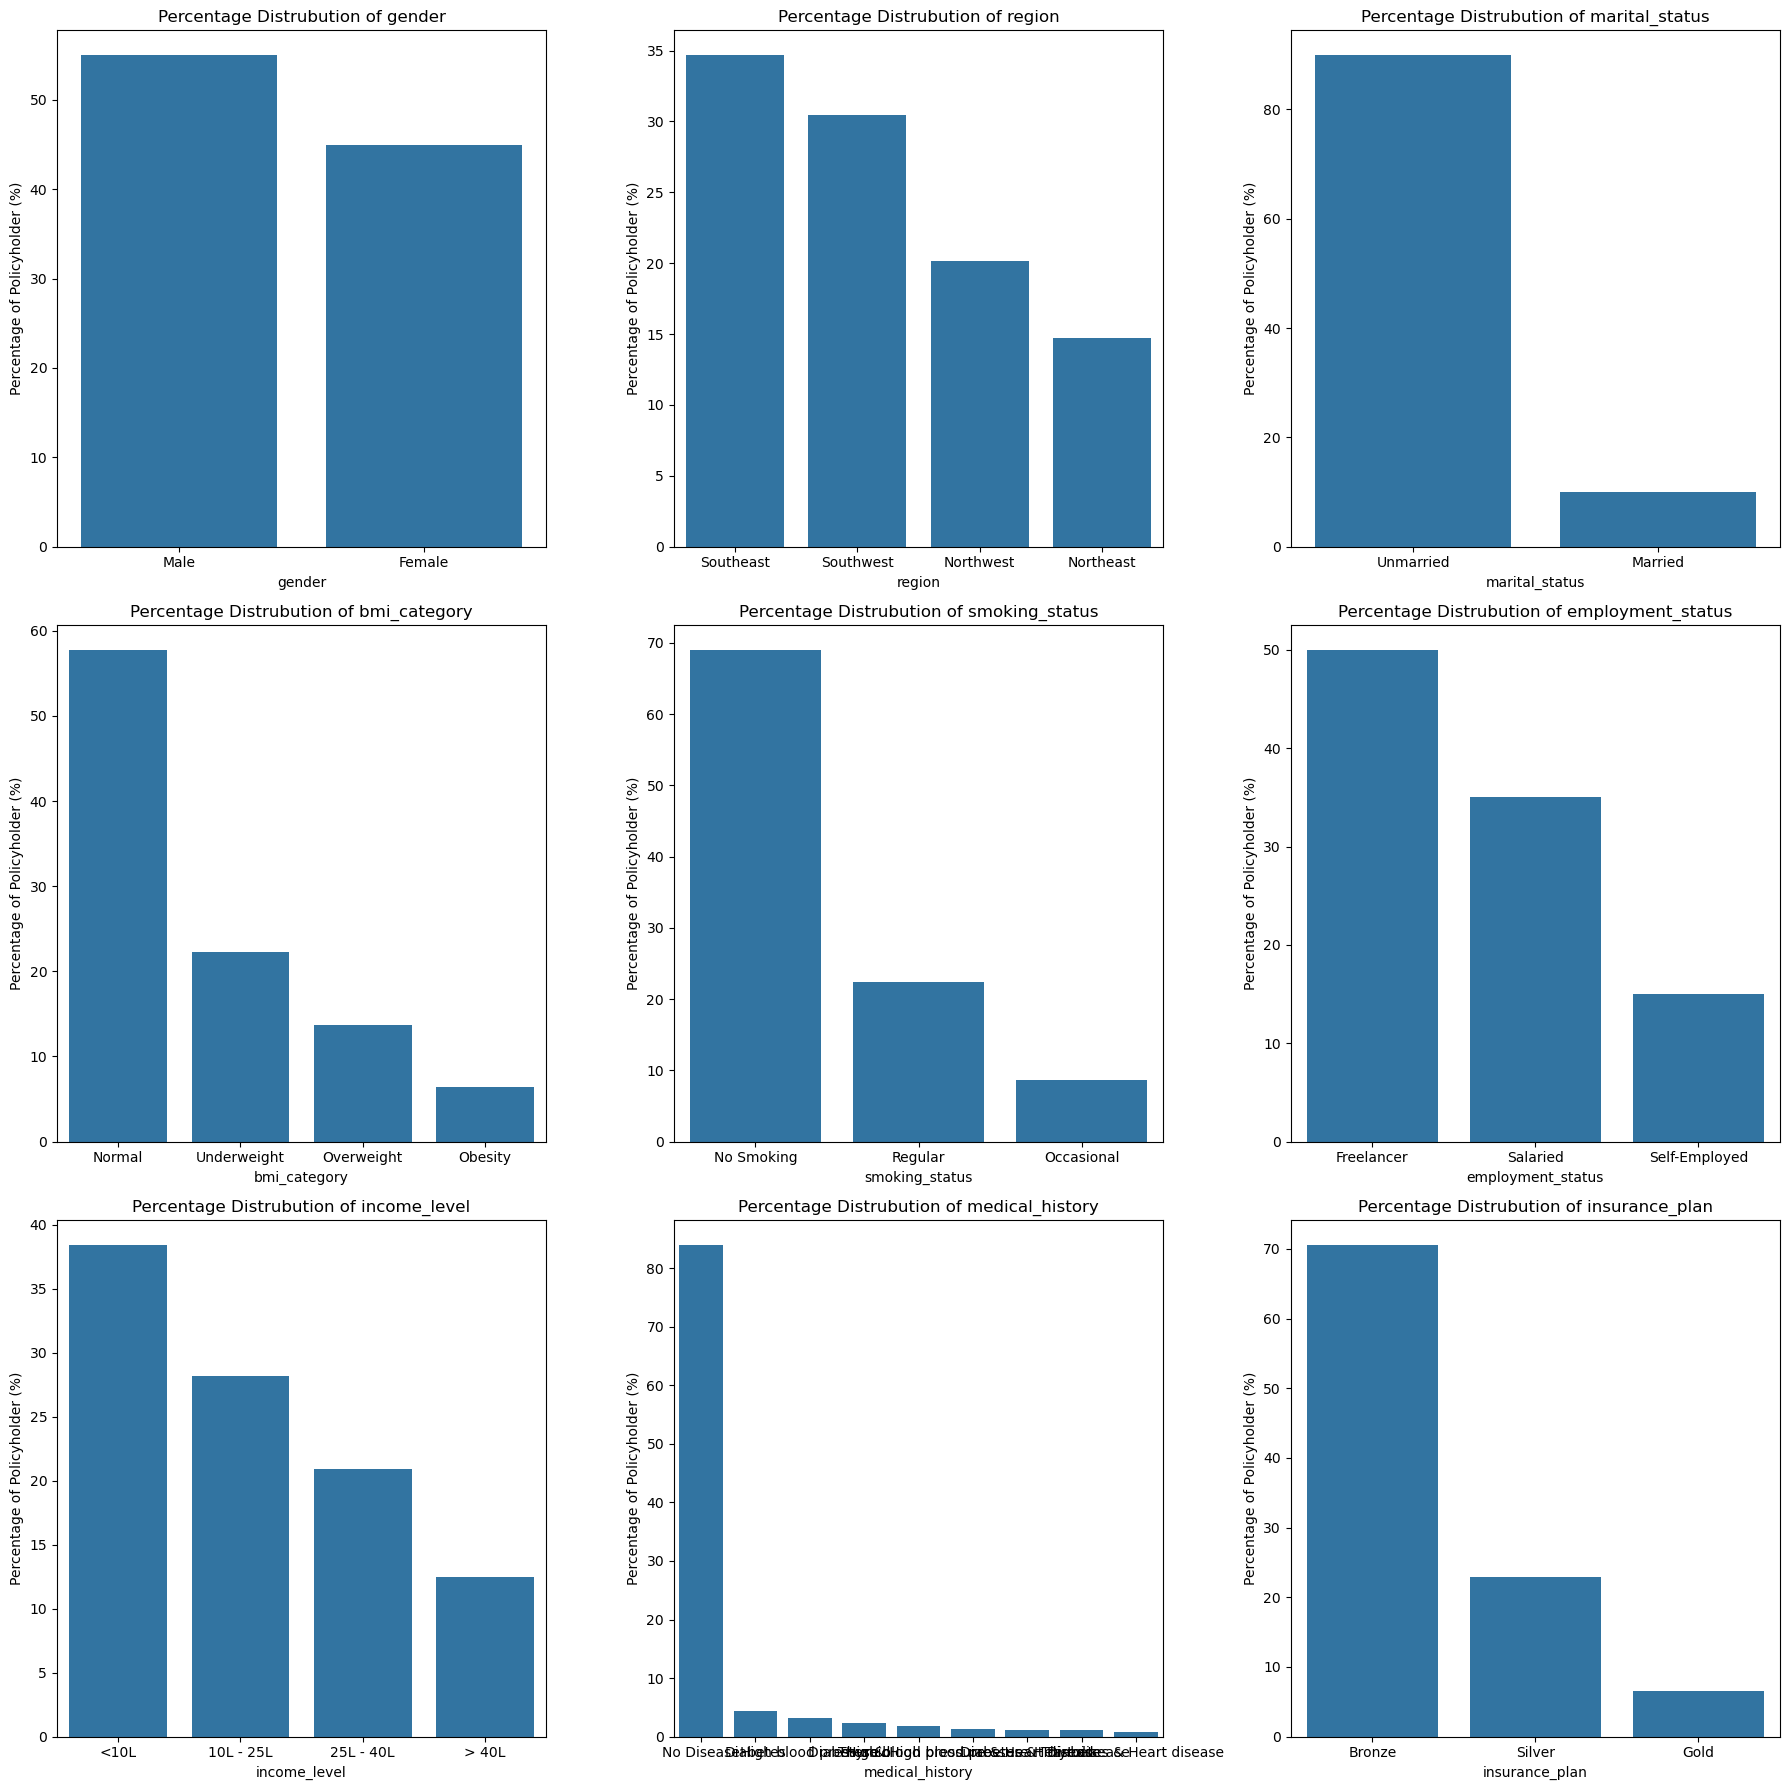

In [79]:
fig, axes = plt.subplots(3,3,figsize=(18,18))
axes = axes.flatten()

for ax, col in zip(axes, categorical_cols):
    categorical_cols = df2[col].value_counts(normalize=True)*100

    sns.barplot(x=categorical_cols.index, y=categorical_cols.values, ax=ax)
    ax.set_title(f'Percentage Distrubution of {col}')
    ax.set_ylabel('Percentage of Policyholder (%)')
    ax.set_xlabel(col)

plt.tight_layout()
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         4508   326     828
25L - 40L         3382   209     608
<10L              6172   404    1145
> 40L              115   366    2023


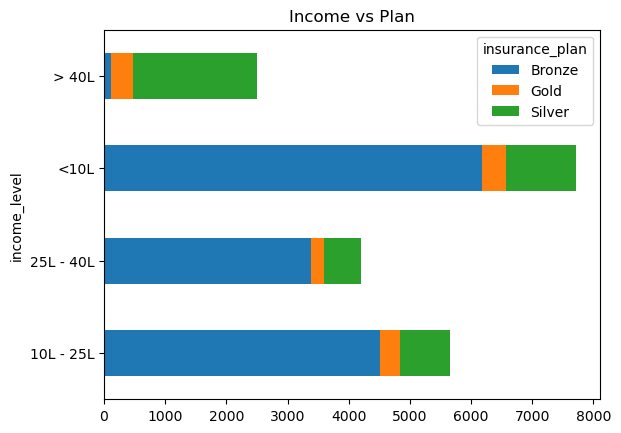

In [80]:
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print(crosstab)
crosstab.plot(kind='barh', stacked=True)
plt.title('Income vs Plan')
plt.show()

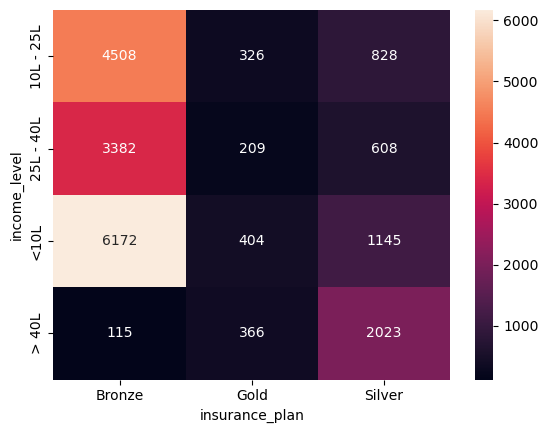

In [81]:
sns.heatmap(crosstab, fmt='d', annot=True)
plt.show()

In [82]:
df2.medical_history.unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [83]:
risk_scores = {
    "diabetes":6,
    "heart disease":8,
    "high blood pressure":6,
    "thyroid":5,
    "no disease":0,
    "none":0
}

df2[['disease1', 'disease2']] = df2['medical_history'].str.split(' & ', expand=True).apply(lambda x:x.str.lower())


In [84]:
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score)/ (max_score - min_score)
df2.sample(10)

,unnamed:_0,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
4478,11029,23,Female,Southwest,Unmarried,0,Normal,Occasional,Self-Employed,25L - 40L,36,No Disease,Bronze,6294,no disease,none,0,0.000000
13591,33809,24,Male,Southwest,Unmarried,1,Overweight,No Smoking,Self-Employed,<10L,7,No Disease,Bronze,7186,no disease,none,0,0.000000
14839,36876,19,Male,Northeast,Married,2,Normal,No Smoking,Salaried,<10L,2,High blood pressure,Bronze,6192,high blood pressure,none,6,0.428571
6923,17139,22,Male,Southwest,Unmarried,0,Normal,Regular,Freelancer,<10L,4,No Disease,Bronze,4843,no disease,none,0,0.000000
14341,35624,24,Male,Southwest,Unmarried,1,Normal,No Smoking,Salaried,<10L,5,No Disease,Bronze,4225,no disease,none,0,0.000000
7198,17849,19,Female,Southeast,Unmarried,1,Normal,No Smoking,Freelancer,<10L,7,No Disease,Bronze,6139,no disease,none,0,0.000000
13706,34082,24,Male,Southeast,Unmarried,1,Normal,No Smoking,Salaried,<10L,6,No Disease,Bronze,8760,no disease,none,0,0.000000
3302,8225,21,Male,Northwest,Unmarried,0,Overweight,Regular,Freelancer,10L - 25L,11,No Disease,Bronze,4903,no disease,none,0,0.000000
14779,36707,24,Female,Northwest,Married,3,Normal,No Smoking,Salaried,<10L,6,No Disease,Bronze,5980,no disease,none,0,0.000000
14755,36666,23,Male,Southeast,Unmarried,1,Normal,No Smoking,Freelancer,25L - 40L,30,No Disease,Bronze,6946,no disease,none,0,0.000000


In [85]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})

In [86]:
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})

In [87]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head()

,unnamed:_0,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,4,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,...,0,0,1,0,1,0,0,1,0,1
1,9,22,0,1,3,No Disease,2,11050,no disease,none,...,0,0,1,0,0,1,0,0,0,0
2,10,21,0,4,97,No Disease,2,11857,no disease,none,...,1,0,1,0,0,0,0,1,1,0
3,16,25,0,2,15,No Disease,1,5684,no disease,none,...,1,0,1,0,0,0,0,0,0,0
4,19,20,2,2,14,No Disease,1,5712,no disease,none,...,1,0,1,0,1,0,0,0,0,0


In [90]:
df4 = df3.drop(['medical_history','disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head(3)

,unnamed:_0,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,4,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,9,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,10,21,0,4,97,2,11857,0.000000,0,0,1,0,1,0,0,0,0,1,1,0


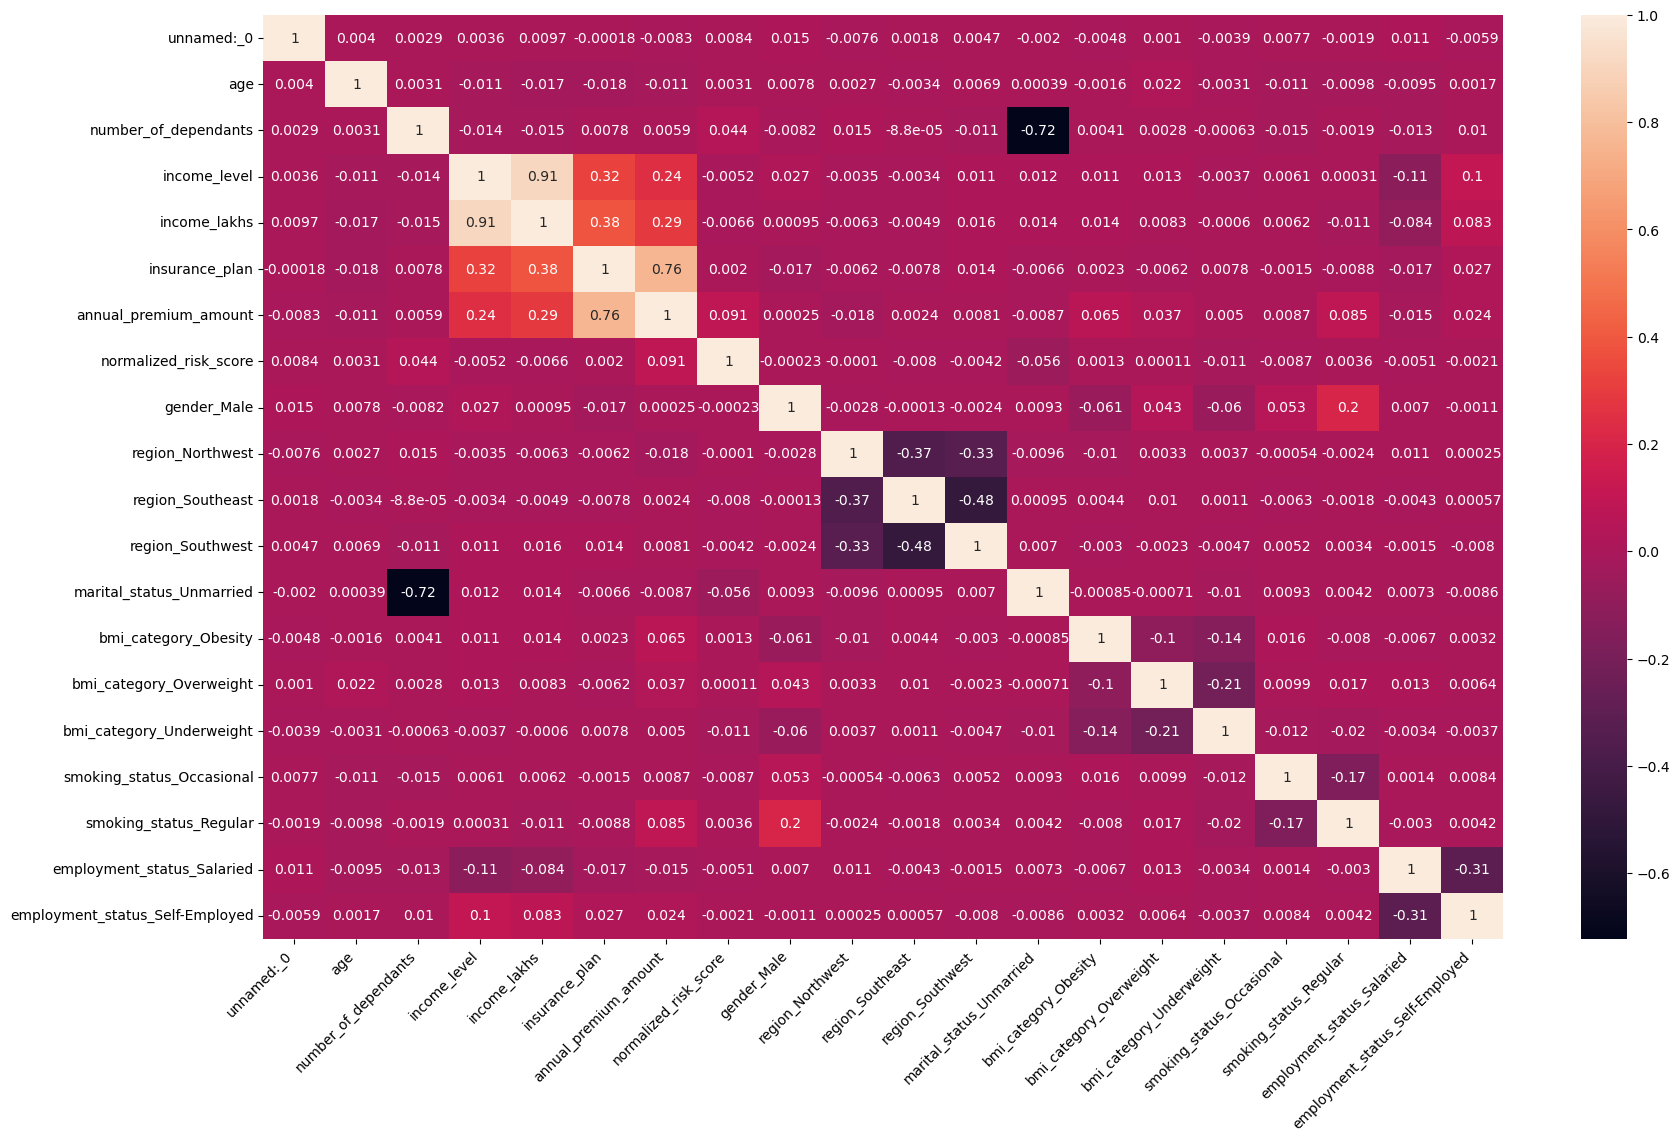

In [92]:
cm = df4.corr()
plt.figure(figsize=(20, 12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.show()

In [99]:
df4.head(2)

,unnamed:_0,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,4,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,9,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0


In [101]:
X = df4.drop('annual_premium_amount', axis=1)
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler
cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.head()

,unnamed:_0,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,4,0.000000,0.000000,1.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,9,0.571429,0.000000,0.000000,0.020202,0.5,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,10,0.428571,0.000000,1.000000,0.969697,0.5,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,16,1.000000,0.000000,0.333333,0.141414,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,19,0.285714,0.666667,0.333333,0.131313,0.0,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


In [102]:
X.shape

(20086, 19)

In [103]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df

In [104]:
calculate_vif(X)

,Column,VIF
0,unnamed:_0,3.732686
1,age,3.156503
2,number_of_dependants,1.960129
3,income_level,11.928709
4,income_lakhs,11.878583
5,insurance_plan,1.592972
6,normalized_risk_score,1.155442
7,gender_Male,2.317017
8,region_Northwest,2.160607
9,region_Southeast,2.996101


In [105]:
calculate_vif(X.drop("income_level" ,axis=1))

,Column,VIF
0,unnamed:_0,3.732685
1,age,3.155160
2,number_of_dependants,1.957493
3,income_lakhs,2.296401
4,insurance_plan,1.587874
5,normalized_risk_score,1.155393
6,gender_Male,2.306849
7,region_Northwest,2.159676
8,region_Southeast,2.994911
9,region_Southwest,2.753184


In [106]:
X_reduced = X.drop('income_level', axis=1)
X_reduced.head()

,unnamed:_0,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,4,0.000000,0.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,9,0.571429,0.000000,0.020202,0.5,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,10,0.428571,0.000000,0.969697,0.5,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,16,1.000000,0.000000,0.141414,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,19,0.285714,0.666667,0.131313,0.0,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


### Model Train

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=10)

print("x train: ", X_train.shape)
print("x test: ", X_test.shape)
print("y train: ", y_train.shape)
print("y test: ", y_test.shape)

x train:  (14060, 18)
x test:  (6026, 18)
y train:  (14060,)
y test:  (6026,)


In [114]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score = model_lr.score(X_train, y_train)
test_score, train_score

(0.6041501846953206, 0.6023184295282523)

In [115]:
feature_importances = model_lr.coef_
pd.DataFrame(feature_importances, index=X_test.columns, columns=['Coefficients'])

,Coefficients
unnamed:_0,-0.003144
age,54.714967
number_of_dependants,-145.334800
income_lakhs,-35.184042
insurance_plan,6999.461355
normalized_risk_score,1115.090090
gender_Male,10.741783
region_Northwest,-115.343278
region_Southeast,-36.926515
region_Southwest,-67.341915


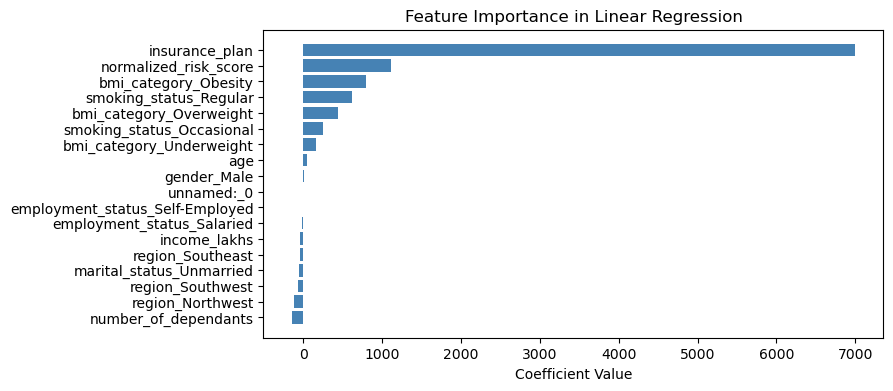

In [117]:
feature_importance = model_lr.coef_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

In [118]:
model_rg = Ridge(alpha=1)
model_rg.fit(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score = model_rg.score(X_train, y_train)
train_score, test_score

(0.6023179652741313, 0.6041630376505931)

In [121]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
model_xgb.score(X_test, y_test)

0.5599888734989049

In [125]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

0.5998367012849478

In [160]:
best_model = model_lr

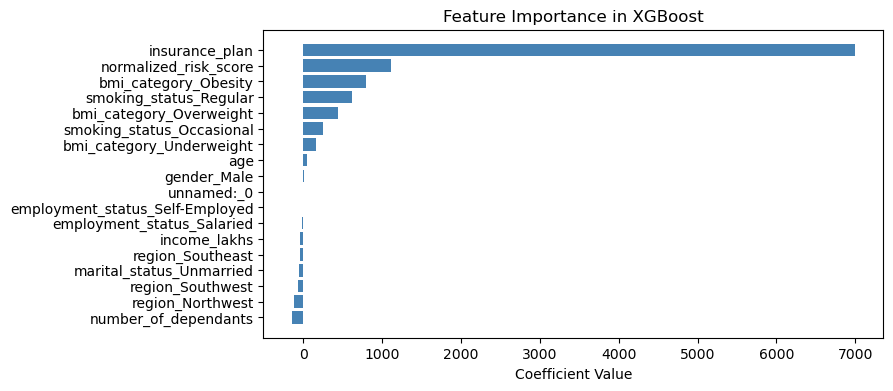

In [164]:
feature_importance = best_model.coef_
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

In [130]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
rediduals_pct = (residuals / y_test) * 100

results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'diff': residuals,
    'diff_pct': rediduals_pct
})
results_df.head()

,actual,predicted,diff,diff_pct
12774,6238,6665.496582,427.496582,6.853103
14758,9462,7027.292480,-2434.707520,-25.731426
13205,5152,7027.292480,1875.292480,36.399311
14278,6988,7814.678711,826.678711,11.829976
19351,4917,6591.625977,1674.625977,34.057880


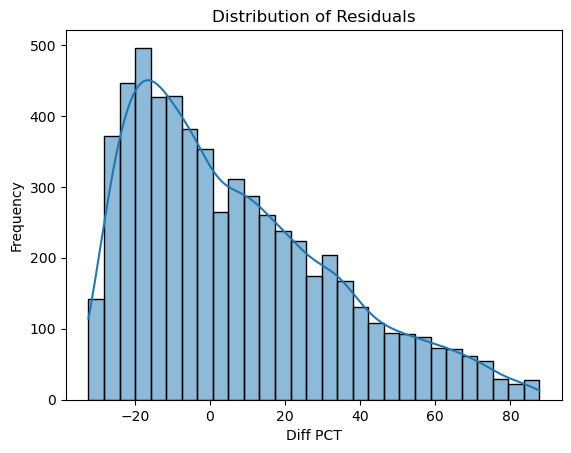

In [132]:
sns.histplot(results_df['diff_pct'], kde=True)
plt.title("Distribution of Residuals")
plt.xlabel('Diff PCT')
plt.ylabel('Frequency')
plt.show()

In [133]:
X_test.shape

(6026, 18)

In [134]:
extreme_error_threshold = 10
extreme_results_df = results_df[np.abs(results_df['diff_pct']) > extreme_error_threshold]
extreme_results_df

,actual,predicted,diff,diff_pct
14758,9462,7027.292480,-2434.707520,-25.731426
13205,5152,7027.292480,1875.292480,36.399311
14278,6988,7814.678711,826.678711,11.829976
19351,4917,6591.625977,1674.625977,34.057880
10622,8947,7168.482910,-1778.517090,-19.878362
...,...,...,...,...
1365,9105,6707.287598,-2397.712402,-26.334019
17652,7635,6586.988281,-1048.011719,-13.726414
5807,4845,7049.108887,2204.108887,45.492443
10298,13866,10975.764648,-2890.235352,-20.844046


In [135]:
extreme_errors_pct = extreme_results_df.shape[0] * 100/ X_test.shape[0]

In [136]:
extreme_errors_pct

73.18287421174908

In [137]:
extreme_results_df[abs(extreme_results_df.diff_pct)>50].sort_values("diff_pct", ascending=False)

,actual,predicted,diff,diff_pct
4692,3516,6600.024414,3084.024414,87.714005
4169,3517,6600.024414,3083.024414,87.660632
42,3602,6733.909180,3131.909180,86.949172
3652,3536,6600.024414,3064.024414,86.652274
12285,3532,6586.988281,3054.988281,86.494572
...,...,...,...,...
14882,4740,7118.520508,2378.520508,50.179758
15383,4390,6586.988281,2196.988281,50.045291
5636,4399,6600.024414,2201.024414,50.034654
545,4684,7027.581543,2343.581543,50.033765


In [138]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head(2)

,unnamed:_0,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
14758,36669,0.285714,0.000000,0.060606,0.0,0.0,0,0,0,1,1,0,0,0,0,1,0,1
13205,32856,0.714286,0.333333,0.141414,0.0,0.0,1,1,0,0,1,0,0,0,0,1,0,1


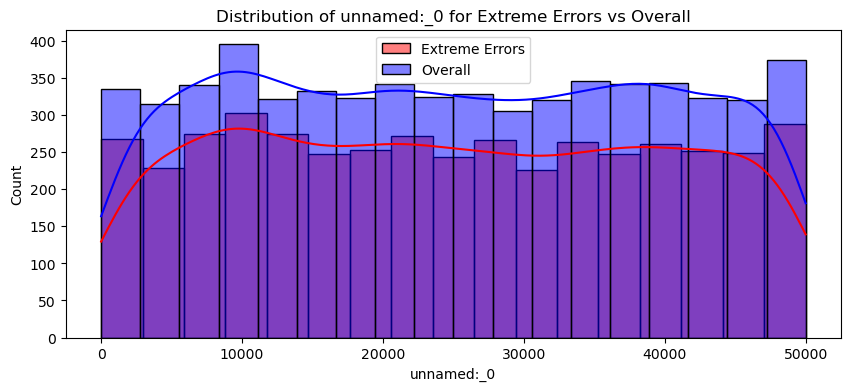

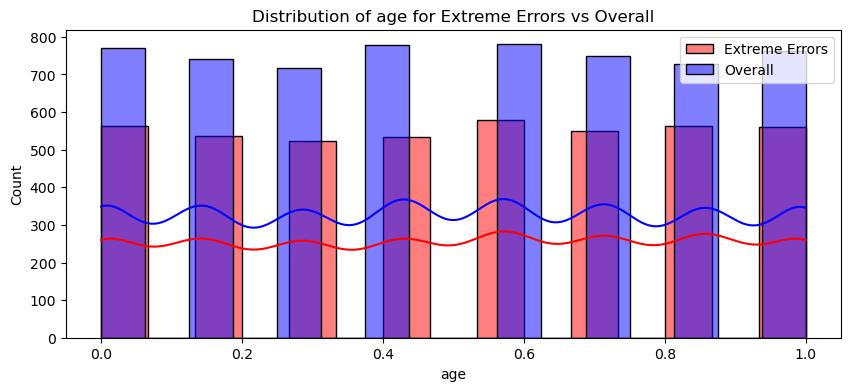

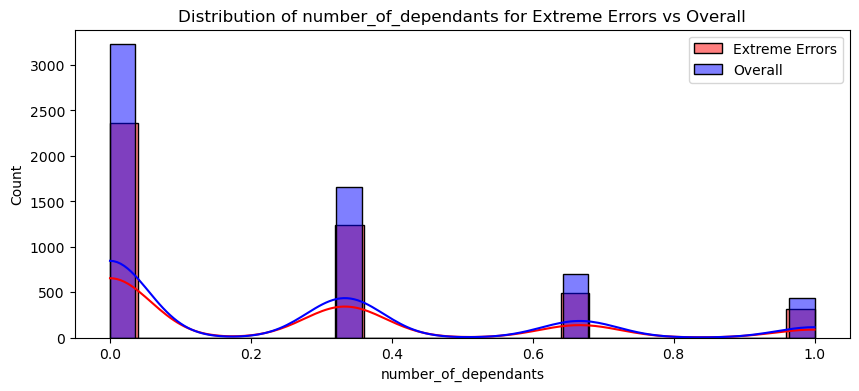

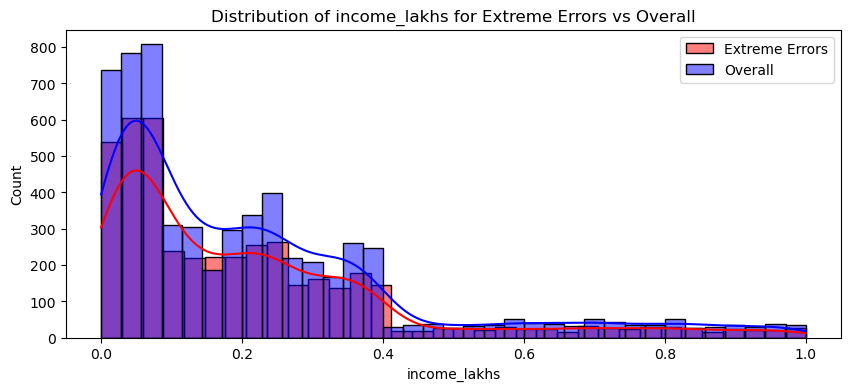

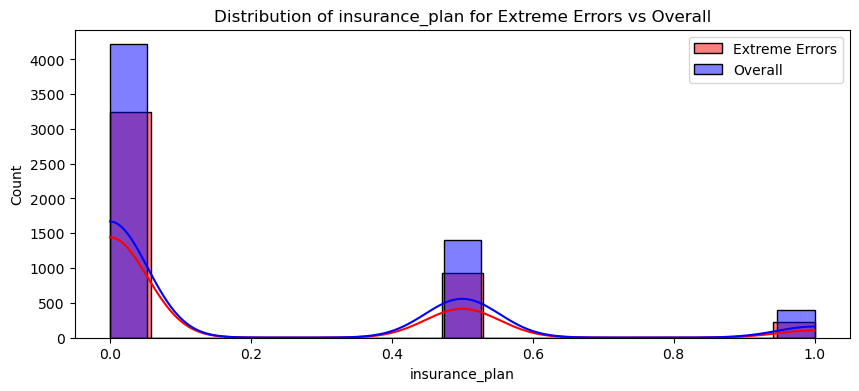

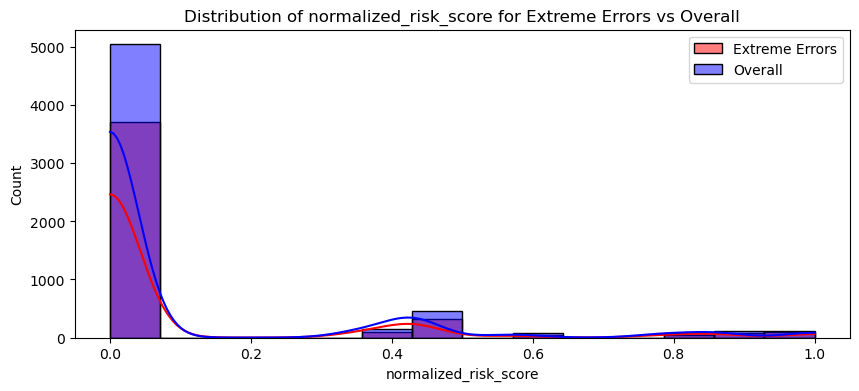

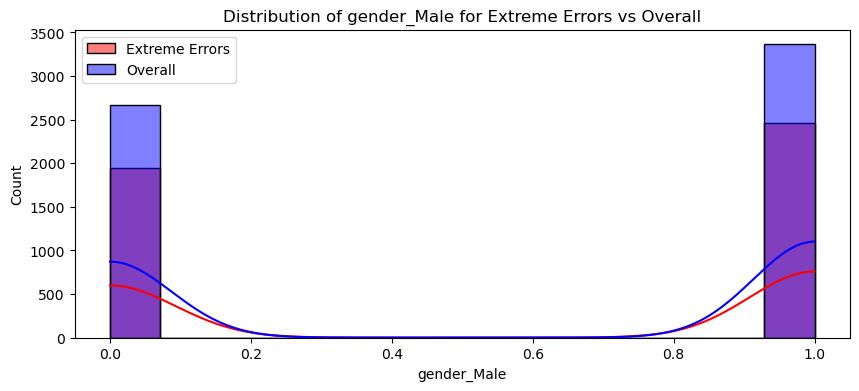

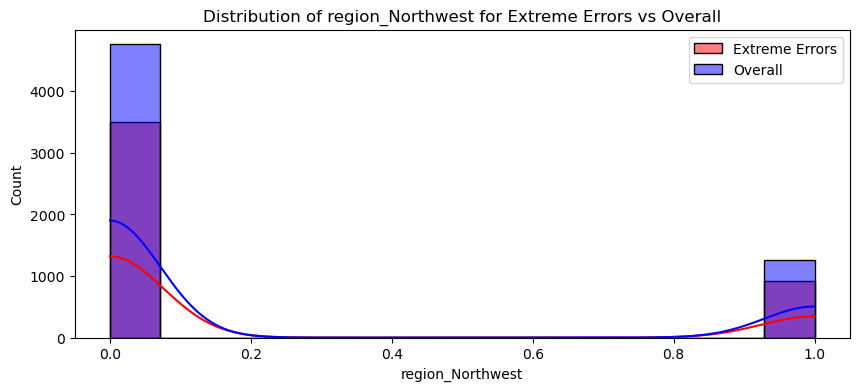

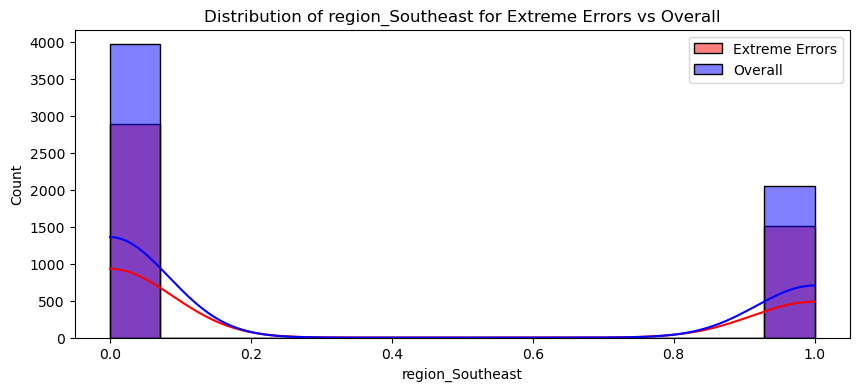

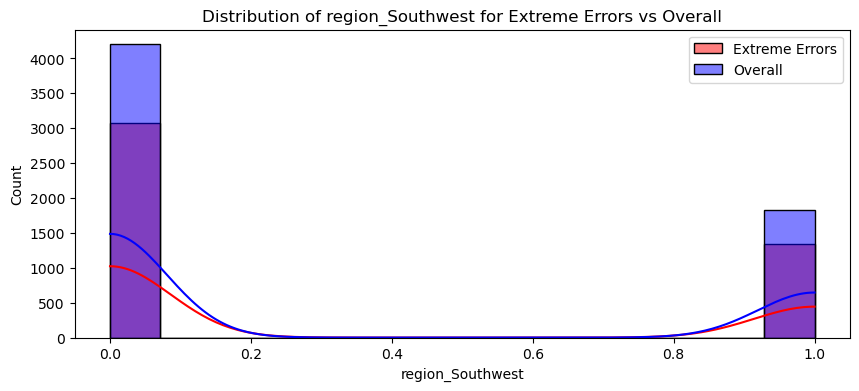

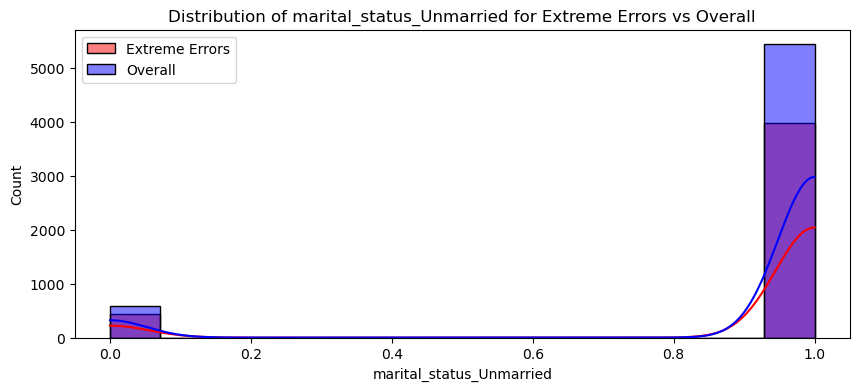

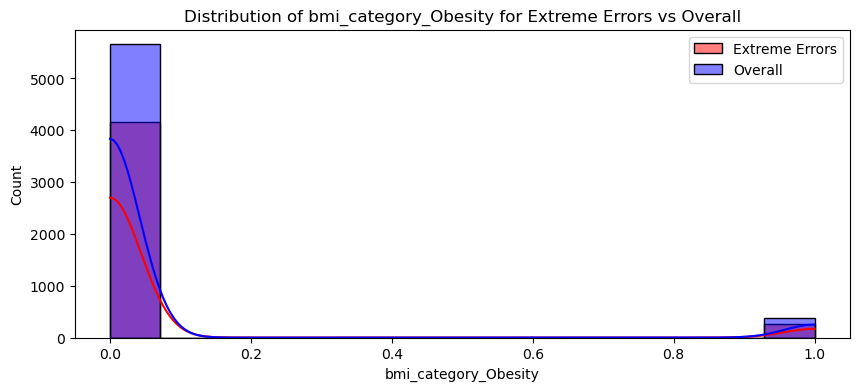

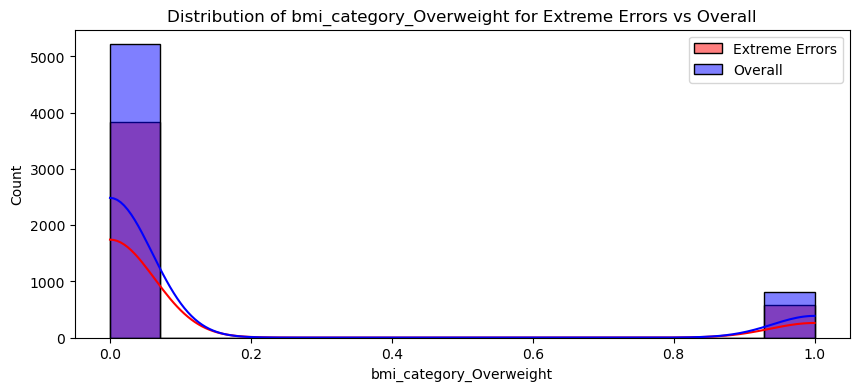

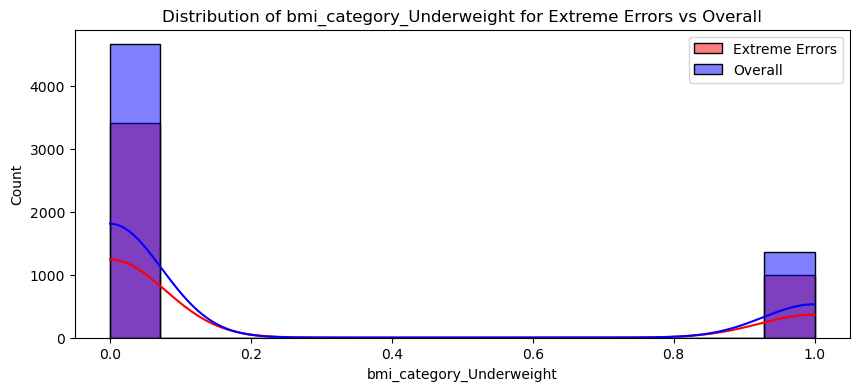

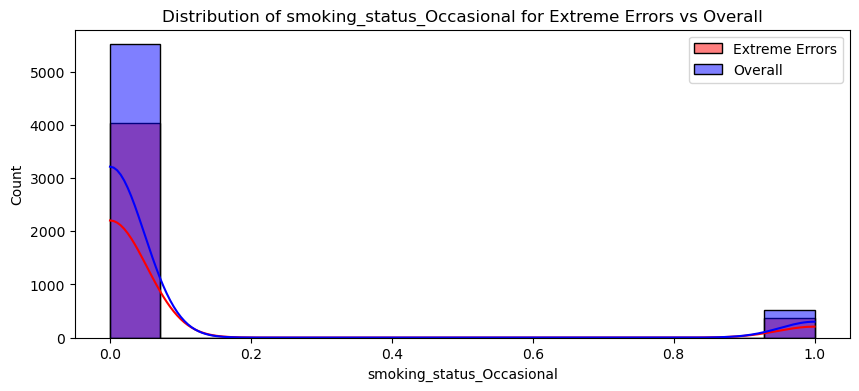

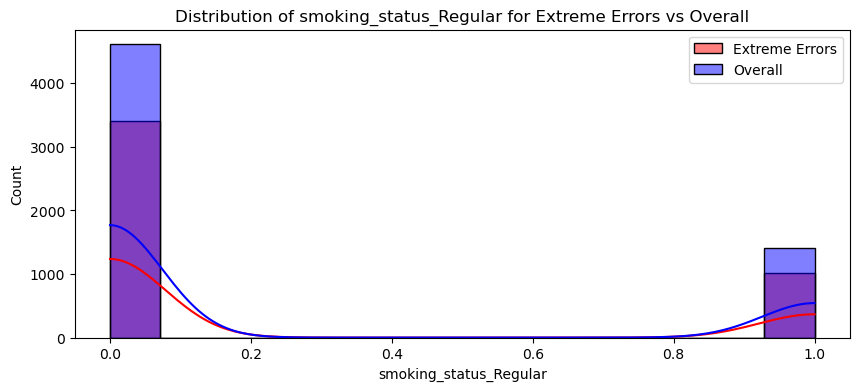

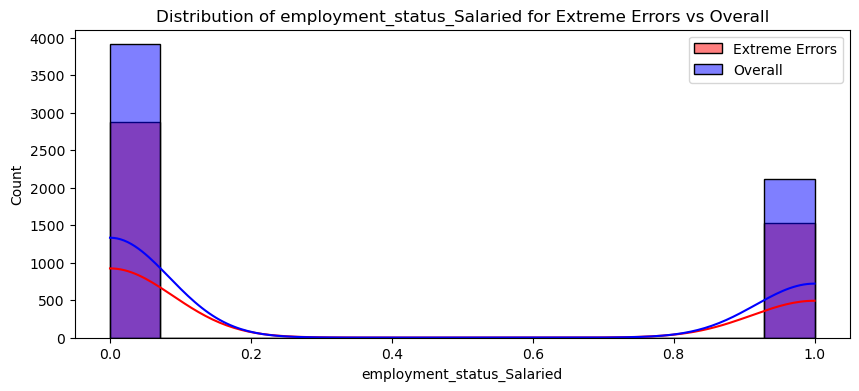

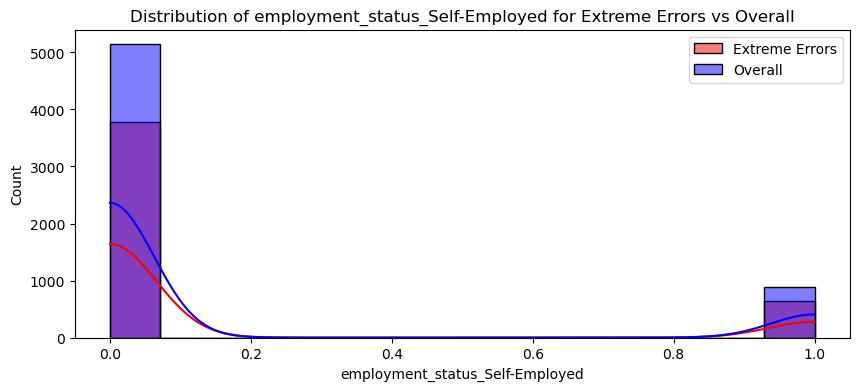

In [139]:
for feature in X_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(extreme_errors_df[feature], color='red', label='Extreme Errors', kde=True)
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()

In [140]:
extreme_errors_df['income_level']=-1

In [141]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,20.0,0.0,-2.0,7.0,1.0
1,23.0,1.0,-2.0,15.0,1.0
2,23.0,1.0,-2.0,23.0,1.0
3,22.0,0.0,-2.0,11.0,1.0
4,21.0,1.0,-2.0,6.0,1.0


In [142]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,4410.000000,4410.000000,4410.0,4410.000000,4410.000000
mean,21.526984,0.721088,-2.0,21.619274,1.315646
std,2.299688,0.926775,0.0,21.089640,0.566435
min,18.000000,0.000000,-2.0,1.000000,1.000000
25%,20.000000,0.000000,-2.0,6.000000,1.000000
50%,22.000000,0.000000,-2.0,15.000000,1.000000
75%,24.000000,1.000000,-2.0,30.000000,2.000000
max,25.000000,3.000000,-2.0,100.000000,3.000000


<Axes: xlabel='age', ylabel='Count'>

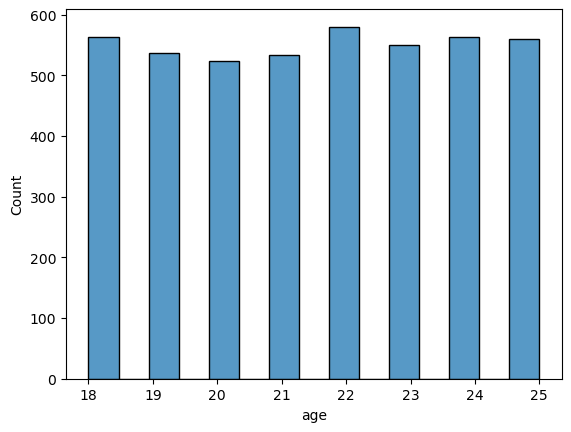

In [143]:
sns.histplot(df_reversed.age)